In [6]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
)
from fairlearn.metrics import MetricFrame
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
import tensorflow as tf
import tensorflow.compat.v1 as tf_v1
from imblearn.over_sampling import SMOTE
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fairlearn.adversarial import AdversarialFairnessRegressor

df = pd.read_csv("all_vals_race1_interestrate1.csv")

df.drop(
    columns=[
        "Unnamed: 0",
        "IsTestData",
        "IsCalibrateData",
        "v1",
        "istestdata2",
        "iscalibratedata2",
    ],
    inplace=True,
)


df["minority"] = (
    (df["race_dum_Black"] == 1) | 
    (df["race_dum_Native Am, Alaska, Hawaii"] == 1) | 
    (df["race_dum_White hisp"] == 1) |
    (df["race_dum_Unknown"] == 1) |
    (df["race_dum_Asian"] == 1)
)

In [7]:
features = df.drop(columns=['Default', "cur_int_rate"], axis=1)

target = df["cur_int_rate"]

race_columns = [
    "race_dum_Unknown",
    "race_dum_Asian",
    "race_dum_Black",
    "race_dum_Native Am, Alaska, Hawaii",
    "race_dum_White hisp",
    "race_dum_White non-hisp",
]


sensitive_features = df[["minority"]].values

(
    X_train,
    X_test,
    y_train,
    y_test,
    sensitive_features_train,
    sensitive_features_test,
) = train_test_split(
    features, target, sensitive_features, test_size=0.3, random_state=42
)

In [8]:
def test_model(mitigator, X_test, y_test, sensitive_features_test):
    y_pred = mitigator.predict(X_test)

    print(f"Predictions: {y_pred[:5]}")  # Display first 5 predictions

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Create DataFrame with results
    y_test_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Disadvantaged': sensitive_features_test.flatten()
    })

    # Calculate metrics for disadvantaged group
    disadvantaged_metrics = y_test_df[y_test_df['Disadvantaged'] == True].agg({
        'Error': ['mean', 'std', 'count'],
        'Actual': 'mean',
        'Predicted': 'mean'
    })

    # Calculate metrics for advantaged group
    advantaged_metrics = y_test_df[y_test_df['Disadvantaged'] == False].agg({
        'Error': ['mean', 'std', 'count'],
        'Actual': 'mean',
        'Predicted': 'mean'
    })

    print("\nDisadvantaged Group Metrics:")
    print(disadvantaged_metrics)

    print("\nAdvantaged Group Metrics:")
    print(advantaged_metrics)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.scatter(
        y_test_df[~y_test_df["Disadvantaged"]]["Actual"],
        y_test_df[~y_test_df["Disadvantaged"]]["Predicted"],
        alpha=0.5,
        label="Advantaged",
    )
    plt.scatter(
        y_test_df[y_test_df["Disadvantaged"]]["Actual"],
        y_test_df[y_test_df["Disadvantaged"]]["Predicted"],
        alpha=0.5,
        label="Disadvantaged",
    )
    plt.plot([4, 6], [4, 6], 'k--')
    plt.xlabel('Actual Interest Rate')
    plt.ylabel('Predicted Interest Rate')
    plt.title('Actual vs Predicted Interest Rates by Group')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(
        y_test_df[~y_test_df["Disadvantaged"]]["Error"],
        alpha=0.5,
        bins=30,
        label="Advantaged",
    )
    plt.hist(
        y_test_df[y_test_df["Disadvantaged"]]["Error"],
        alpha=0.5,
        bins=30,
        label="Disadvantaged",
    )
    plt.xlabel('Prediction Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors by Group')
    plt.legend()
    plt.grid(True)
    plt.show()


def metrics(mitigator, X_test, y_test, sensitive_features_test):
    y_pred = mitigator.predict(X_test)
    mf = MetricFrame(
        metrics=mean_absolute_error,
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=sensitive_features_test,
    )
    
    print("MAE by group:")
    print(mf.by_group)

    print("\nDisparity (difference between max and min MAE):")
    print(mf.difference())

In [ ]:
predictor_model0 = Sequential(
    [
        Dense(1024, activation="relu"),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear"),
    ]
)

adversary_model0 = Sequential(
    [
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

mitigator0 = AdversarialFairnessRegressor(
    predictor_model=predictor_model0,
    adversary_model=adversary_model0,
    random_state=42,
    alpha=0,
    batch_size=32,
    epochs=50,
    progress_updates=100,
)

mitigator0.fit(
    X_train,
    y_train,
    sensitive_features=sensitive_features_train,
)

test_model(mitigator0, X_test, y_test, sensitive_features_test)

making fairness model


Predictions: [4.7997103 4.7050123 5.056122  4.951806  5.347743 ]
Mean Squared Error: 0.0615
Root Mean Squared Error: 0.2479
Mean Absolute Error: 0.1937
R² Score: 0.6472

Disadvantaged Group Metrics:
             Error    Actual  Predicted
mean      0.127778  5.013698    4.88592
std       0.203889       NaN        NaN
count  1048.000000       NaN        NaN

Advantaged Group Metrics:
             Error    Actual  Predicted
mean      0.117656  5.024569   4.906913
std       0.220560       NaN        NaN
count  3774.000000       NaN        NaN


c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(


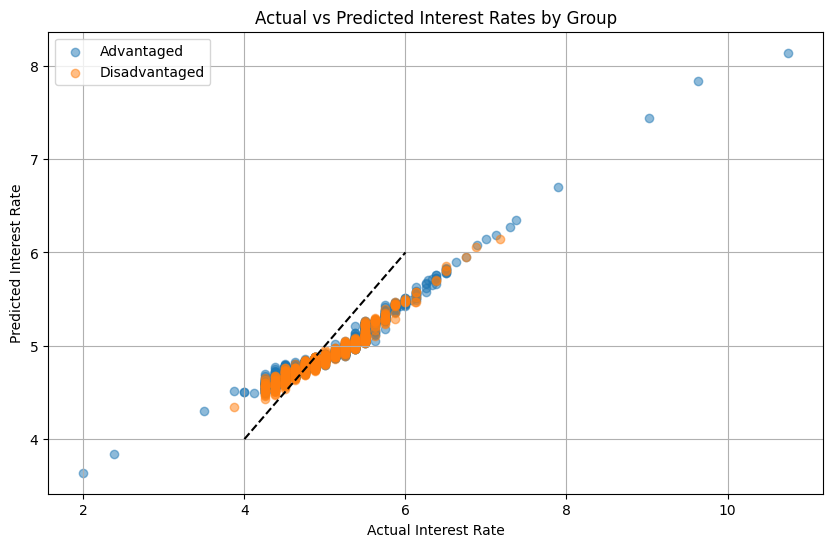

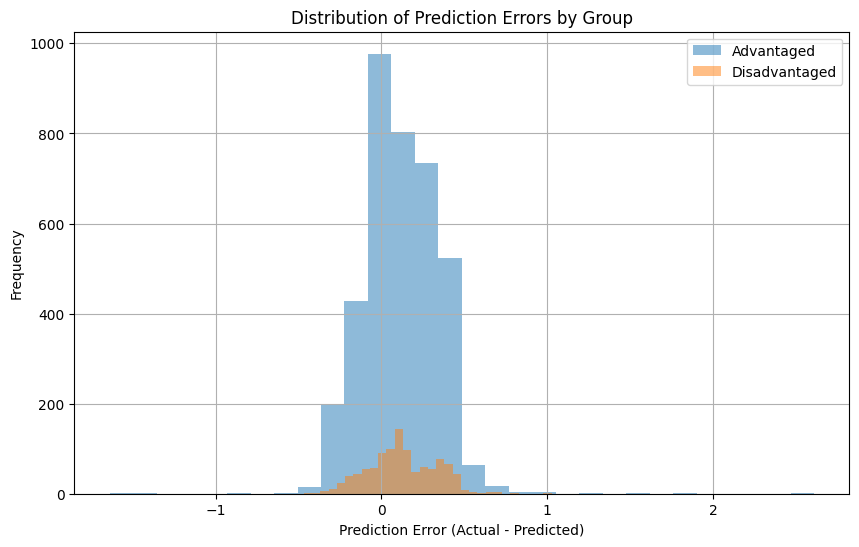

In [ ]:
predictor_model01 = Sequential(
    [
        Dense(1024, activation="relu"),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear"),
    ]
)

adversary_model01 = Sequential(
    [
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

mitigator01 = AdversarialFairnessRegressor(
    predictor_model=predictor_model0,
    adversary_model=adversary_model0,
    random_state=42,
    alpha=0.1,
    batch_size=32,
    epochs=50,
    progress_updates=100,
)

mitigator01.fit(
    X_train,
    y_train,
    sensitive_features=sensitive_features_train,
)

test_model(mitigator01, X_test, y_test, sensitive_features_test)

c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(


Predictions: [4.9047203 4.75358   5.278221  5.1601825 5.4023314]
Mean Squared Error: 0.0528
Root Mean Squared Error: 0.2297
Mean Absolute Error: 0.1477
R² Score: 0.6972

Disadvantaged Group Metrics:
             Error    Actual  Predicted
mean     -0.016684  5.013698   5.030383
std       0.207748       NaN        NaN
count  1048.000000       NaN        NaN

Advantaged Group Metrics:
             Error    Actual  Predicted
mean     -0.017421  5.024569    5.04199
std       0.234715       NaN        NaN
count  3774.000000       NaN        NaN


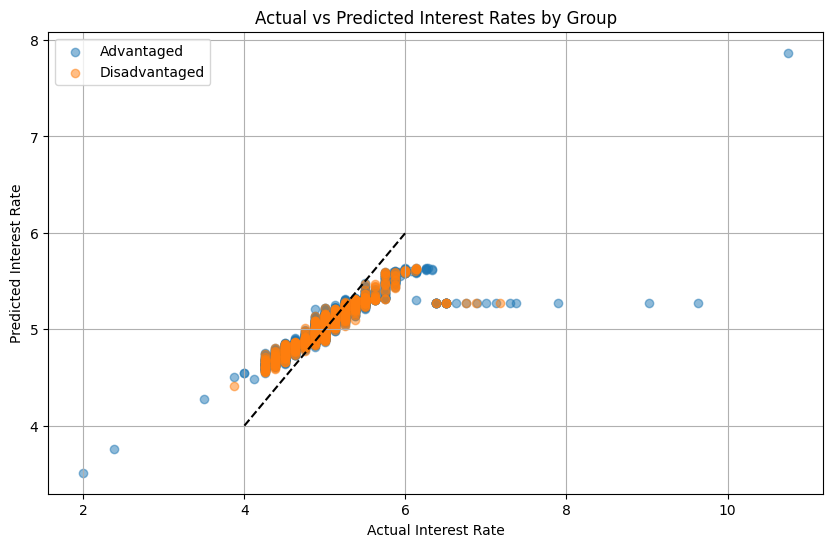

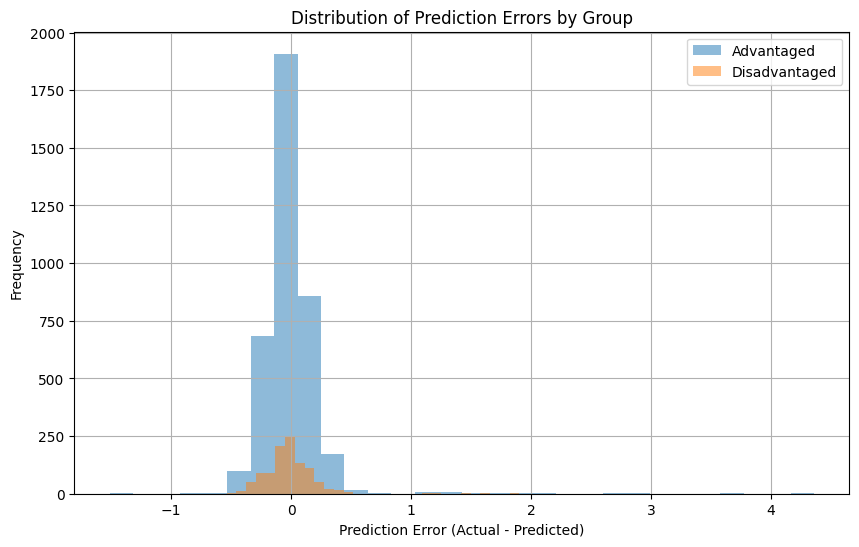

In [ ]:
predictor_model1 = Sequential(
    [
        Dense(1024, activation="relu"),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear"),
    ]
)

adversary_model1 = Sequential(
    [
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

mitigator1 = AdversarialFairnessRegressor(
    predictor_model=predictor_model1,
    adversary_model=adversary_model1,
    random_state=42,
    alpha=1,
    batch_size=32,
    epochs=100,
    progress_updates=1,
)

mitigator1.fit(
    X_train,
    y_train,
    sensitive_features=sensitive_features_train,
)

test_model(mitigator1, X_test, y_test, sensitive_features_test) 

c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(


Predictions: [4.817785  4.691244  5.311754  5.153906  5.4821577]
Mean Squared Error: 0.0184
Root Mean Squared Error: 0.1356
Mean Absolute Error: 0.1052
R² Score: 0.8944

Disadvantaged Group Metrics:
             Error    Actual  Predicted
mean      0.060016  5.013698   4.953682
std       0.125700       NaN        NaN
count  1048.000000       NaN        NaN

Advantaged Group Metrics:
             Error    Actual  Predicted
mean      0.047405  5.024569   4.977163
std       0.126019       NaN        NaN
count  3774.000000       NaN        NaN


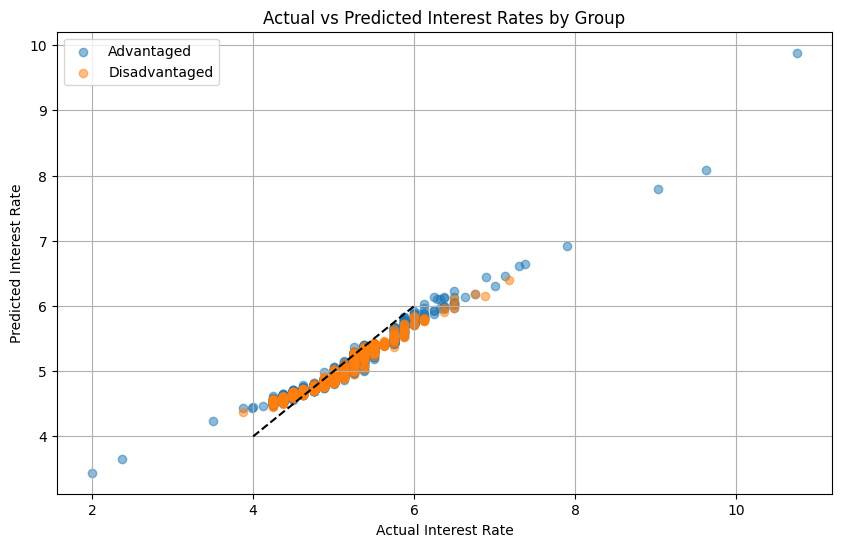

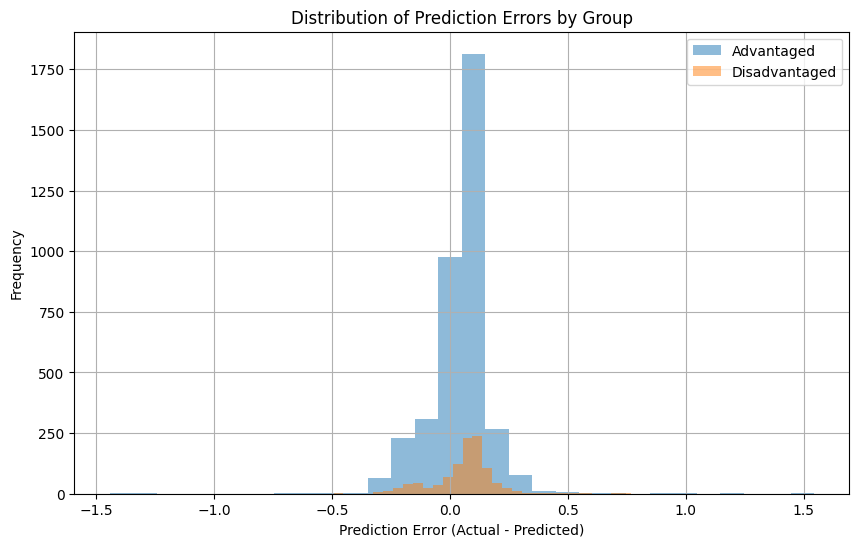

In [ ]:
predictor_model05 = Sequential(
    [
        Dense(1024, activation="relu"),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear"),
    ]
)

adversary_model05 = Sequential(
    [
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

mitigator05 = AdversarialFairnessRegressor(
    predictor_model=predictor_model05,
    adversary_model=adversary_model05,
    random_state=42,
    alpha=0.5,
    batch_size=32,
    epochs=100,
    progress_updates=1,
)

mitigator05.fit(
    X_train,
    y_train,
    sensitive_features=sensitive_features_train,
)

test_model(mitigator05, X_test, y_test, sensitive_features_test)

c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(


Predictions: [4.809802  4.6048684 5.2214937 5.1333094 5.439141 ]
Mean Squared Error: 0.0309
Root Mean Squared Error: 0.1756
Mean Absolute Error: 0.1344
R² Score: 0.8230

Disadvantaged Group Metrics:
             Error    Actual  Predicted
mean      0.084057  5.013698   4.929642
std       0.142454       NaN        NaN
count  1048.000000       NaN        NaN

Advantaged Group Metrics:
             Error    Actual  Predicted
mean      0.088416  5.024569   4.936152
std       0.154976       NaN        NaN
count  3774.000000       NaN        NaN


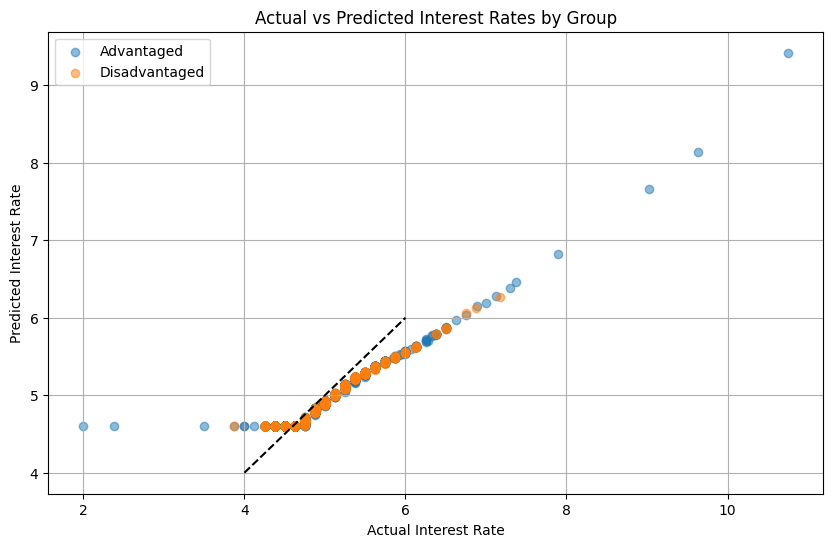

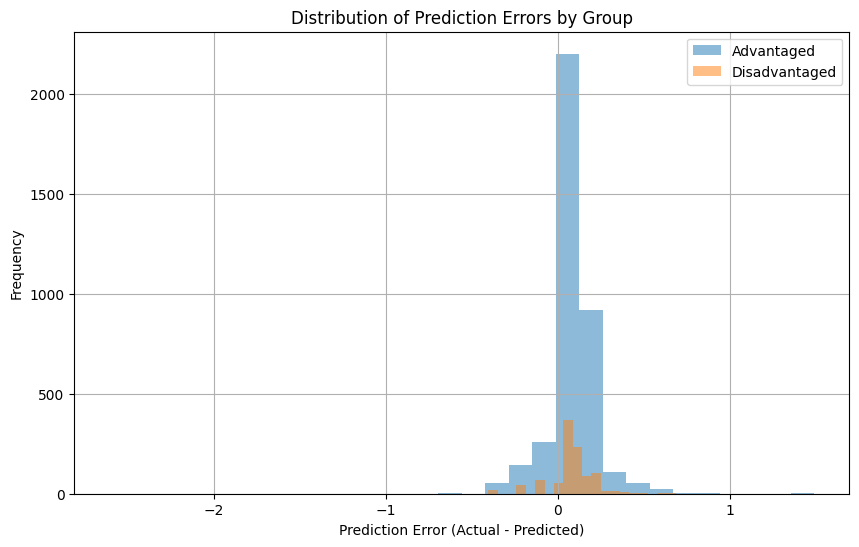

In [ ]:
predictor_model5 = Sequential(
    [
        Dense(1024, activation="relu"),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear"),
    ]
)

adversary_model5 = Sequential(
    [
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

mitigator5 = AdversarialFairnessRegressor(
    predictor_model=predictor_model5,
    adversary_model=adversary_model5,
    random_state=42,
    alpha=5,
    batch_size=32,
    epochs=100,
    progress_updates=1,
)

mitigator5.fit(
    X_train,
    y_train,
    sensitive_features=sensitive_features_train,
)

test_model(mitigator5, X_test, y_test, sensitive_features_test)

c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(


Predictions: [4.994068  4.763818  5.331605  5.2277527 5.563429 ]
Mean Squared Error: 0.0302
Root Mean Squared Error: 0.1737
Mean Absolute Error: 0.1332
R² Score: 0.8268

Disadvantaged Group Metrics:
             Error    Actual  Predicted
mean     -0.077740  5.013698   5.091438
std       0.149656       NaN        NaN
count  1048.000000       NaN        NaN

Advantaged Group Metrics:
             Error    Actual  Predicted
mean     -0.075157  5.024569   5.099726
std       0.158222       NaN        NaN
count  3774.000000       NaN        NaN


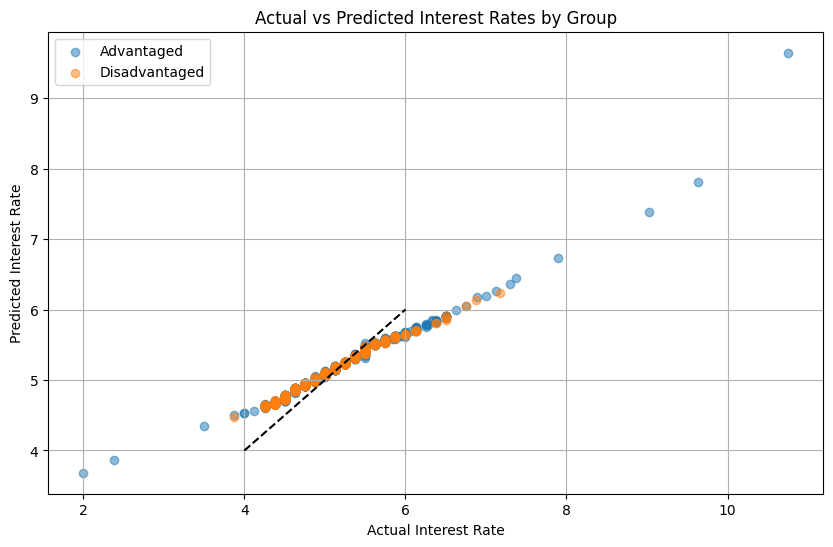

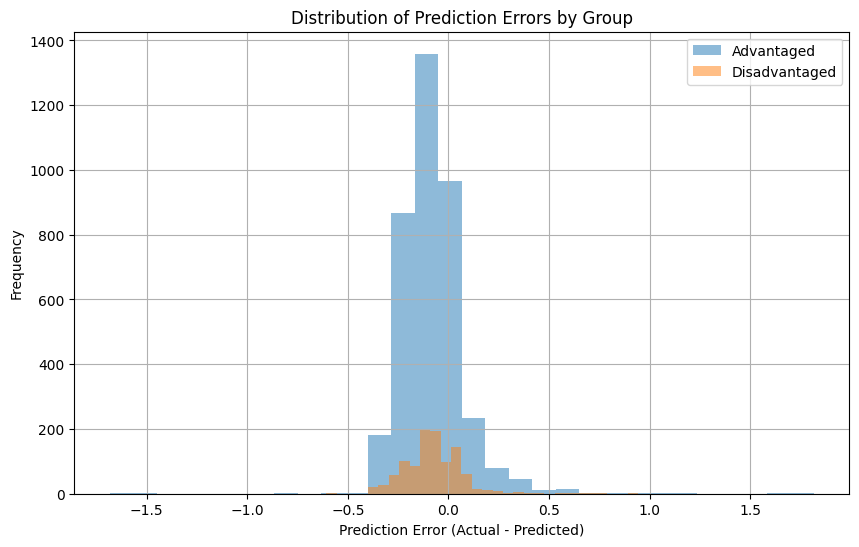

In [ ]:
predictor_model001 = Sequential(
    [
        Dense(1024, activation="relu"),
        Dropout(0.2),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="linear"),
    ]
)

adversary_model001 = Sequential(
    [
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

mitigator001 = AdversarialFairnessRegressor(
    predictor_model=predictor_model001,
    adversary_model=adversary_model001,
    random_state=42,
    alpha=0.01,
    batch_size=32,
    epochs=100,
    progress_updates=1,
)

mitigator001.fit(
    X_train,
    y_train,
    sensitive_features=sensitive_features_train,
)

test_model(mitigator001, X_test, y_test, sensitive_features_test)

In [ ]:
# y_pred = mitigator.predict(X_test)


# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# precision = precision_score(y_test, y_pred)
# print(f"Precision: {precision:.4f}")

# conf_matrix = confusion_matrix(y_test, y_pred)
# print("\nConfusion Matrix:")
# print(conf_matrix)

# class_report = classification_report(y_test, y_pred)
# print("\nClassification Report:")
# print(class_report)

In [ ]:
# Metrics

metric_results = metrics(mitigator0, X_test, y_test, sensitive_features_test)

metric_results = metrics(mitigator01, X_test, y_test, sensitive_features_test)

metric_results = metrics(mitigator1, X_test, y_test, sensitive_features_test)


Sensitive features distribution in test data:
  False: 4525
  True: 297
MAE by group:
sensitive_feature_0
False    0.109866
True     0.133297
Name: mean_absolute_error, dtype: float64

Disparity (difference between max and min MAE):
0.02343127484407724

Sensitive features distribution in test data:
  False: 4525
  True: 297
MAE by group:
sensitive_feature_0
False    0.286881
True     0.339872
Name: mean_absolute_error, dtype: float64

Disparity (difference between max and min MAE):
0.05299144192490235

Sensitive features distribution in test data:
  False: 4525
  True: 297
MAE by group:
sensitive_feature_0
False    0.332714
True     0.310102
Name: mean_absolute_error, dtype: float64

Disparity (difference between max and min MAE):
0.022612194998342106


c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(
c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(
c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(


In [ ]:
# Display summary of the adversary model
mitigator001.adversary_model.summary()

# Display summary of the predictor model
print("\nPredictor Model Summary:")
mitigator001.predictor_model.summary()

# Check input shape
print("\nAdversary Model Input Shape:", mitigator001.adversary_model.input_shape)
print("Predictor Model Input Shape:", mitigator001.predictor_model.input_shape)

# Check the structure of the models
print("\nAdversary Model Layers:")
for i, layer in enumerate(mitigator1.adversary_model.layers):
    print(f"Layer {i}: {layer.name}, Type: {type(layer).__name__}")

print("\nPredictor Model Layers:")
for i, layer in enumerate(mitigator1.predictor_model.layers):
    print(f"Layer {i}: {layer.name}, Type: {type(layer).__name__}")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (32, 256)              │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,777 (171.00 KB)

 Trainable params: 43,777 (171.00 KB)

 Non-trainable params: 0 (0.00 B)


Predictor Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (32, 1024)             │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (32, 512)              │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (32, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (32, 256)              │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (32, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,385 (2.99 MB)

 Trainable params: 784,385 (2.99 MB)

 Non-trainable params: 0 (0.00 B)


Adversary Model Input Shape: (32, 1)
Predictor Model Input Shape: (32, 82)

Adversary Model Layers:
Layer 0: dense_31, Type: Dense
Layer 1: dropout_26, Type: Dropout
Layer 2: dense_32, Type: Dense
Layer 3: dropout_27, Type: Dropout
Layer 4: dense_33, Type: Dense
Layer 5: dropout_28, Type: Dropout
Layer 6: dense_34, Type: Dense
Layer 7: dropout_29, Type: Dropout
Layer 8: dense_35, Type: Dense

Predictor Model Layers:
Layer 0: dense_24, Type: Dense
Layer 1: dropout_20, Type: Dropout
Layer 2: dense_25, Type: Dense
Layer 3: dropout_21, Type: Dropout
Layer 4: dense_26, Type: Dense
Layer 5: dropout_22, Type: Dropout
Layer 6: dense_27, Type: Dense
Layer 7: dropout_23, Type: Dropout
Layer 8: dense_28, Type: Dense
Layer 9: dropout_24, Type: Dropout
Layer 10: dense_29, Type: Dense
Layer 11: dropout_25, Type: Dropout
Layer 12: dense_30, Type: Dense


In [ ]:
y_pred = mitigator0.predict(X_test)
disadvantaged_prediction = mitigator0.adversary_model.predict(y_pred)

print(f"Disadvantaged Predictions (first 5): {disadvantaged_prediction[:5]}")  # Display first 5 predictions

# Convert predictions to binary (0.5 threshold) for accuracy calculation
binary_predictions = (disadvantaged_prediction > 0.5).astype(int)
# Count occurrences of 0s and 1s in binary_predictions
unique, counts = np.unique(binary_predictions, return_counts=True)
print(f"Binary prediction counts: {dict(zip(unique, counts))}")
acc_score = accuracy_score(sensitive_features_test, binary_predictions)
print(f"Accuracy score: {acc_score:.4f}")

 73/151 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step

c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but AdversarialFairnessRegressor was fitted without feature names
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
Disadvantaged Predictions (first 5): [[0.2058878 ]
 [0.20574813]
 [0.20602944]
 [0.20600785]
 [0.20611225]]
Binary prediction counts: {np.int64(0): np.int64(4822)}
Accuracy score: 0.7827


In [ ]:
import os
import json
from tensorflow.keras.models import load_model as tf_load_model

# Create a directory to save models if it doesn't exist
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save all the trained models
models_to_save = {
    "mitigator0": mitigator0,
    "mitigator001": mitigator001,
    "mitigator01": mitigator01, 
    "mitigator05": mitigator05,
    "mitigator1": mitigator1,
    "mitigator5": mitigator5
}

# Save each model
for model_name, model in models_to_save.items():
    # Check if predictor_model and adversary_model are available
    if hasattr(model, 'predictor_model') and model.predictor_model is not None:
        model.predictor_model.save(os.path.join(save_dir, f"{model_name}_predictor.keras"))
    else:
        print(f"Warning: {model_name} doesn't have a valid predictor_model to save")
        
    if hasattr(model, 'adversary_model') and model.adversary_model is not None:
        model.adversary_model.save(os.path.join(save_dir, f"{model_name}_adversary.keras"))
    else:
        print(f"Warning: {model_name} doesn't have a valid adversary_model to save")
    
    # Instead of trying to pickle the whole object, save the essential parameters
    # as a JSON file that we can use to recreate the model
    model_config = {
        "alpha": float(model.alpha),  # Convert to native Python float for JSON serialization
        "batch_size": int(model.batch_size),
        "random_state": int(model.random_state) if model.random_state is not None else None,
        "epochs": int(model.epochs),
        "progress_updates": int(model.progress_updates)
    }
    
    with open(os.path.join(save_dir, f"{model_name}_config.json"), "w") as f:
        json.dump(model_config, f)

print("All models saved to", save_dir)

# Example of how to load a model (for future reference)
def load_model(model_name, save_dir="saved_models"):
    from fairlearn.adversarial import AdversarialFairnessRegressor
    
    # Load the model configuration
    with open(os.path.join(save_dir, f"{model_name}_config.json"), "r") as f:
        config = json.load(f)
    
    # Load the TensorFlow models
    predictor_model = tf_load_model(os.path.join(save_dir, f"{model_name}_predictor.keras"))
    adversary_model = tf_load_model(os.path.join(save_dir, f"{model_name}_adversary.keras"))
    
    # Create a new mitigator with the loaded configuration
    mitigator = AdversarialFairnessRegressor(
        predictor_model=predictor_model,
        adversary_model=adversary_model,
        alpha=config["alpha"],
        batch_size=config["batch_size"],
        random_state=config["random_state"],
        epochs=config["epochs"],
        progress_updates=config["progress_updates"]
    )
    
    # The model will need to be refitted or restored from a trained state
    # This function only restores the architecture and hyperparameters
    return mitigator

# To test loading a model and making predictions
# loaded_mitigator0 = load_model("mitigator0")
# test_predictions = loaded_mitigator0.predict(X_test[:5])  # Test on a small sample
# print("Test predictions:", test_predictions)

All models saved to saved_models


NotFittedError: This AdversarialFairnessRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.